In [2]:
import json

import pandas
import seaborn

import scipy.stats

In [3]:
pandas.set_option('display.float_format', lambda x: f'{x:,.6f}')

In [4]:
COUNTRY_FILTER = [
    "France",
    "Egypt",
    "Saudi Arabia",
    "Russia",
    "Mexico",
    "Japan",
]

MODEL_FILTER = ["human", "llama3.1:8b", "mistral:7b"]

In [5]:
dataset_long = pandas.read_parquet("reports/dataset.long.parquet")
dataset_long

dimension  response
segment         id model       persona                      
descriptiveness 1  llama3.1:8b Argentina      care  5.000000
                               Argentina      care  5.000000
                               Argentina      care  5.000000
                               Argentina      care  5.000000
                               Argentina      care  5.000000
...                                            ...       ...
                36 qwen2.5:7b  UAE          purity  3.000000
                               UAE          purity  3.000000
                               UAE          purity  3.000000
                               UAE          purity  3.000000
                               UAE          purity  3.000000

[166255 rows x 2 columns]

In [6]:
dataset_long_human = (
    pandas.DataFrame(json.load(open("../../../data/moral_foundations_2/surveys.json"))["atari_et_al"]["country"])
    .T
    .melt(ignore_index=False)
    .reset_index()
    .rename(columns={
        "index": "persona",
        "variable": "dimension",
        "value": "response",
    })
    .assign(model="human")
)
dataset_long_human

,persona,dimension,response,model
0,Argentina,care,3.840000,human
1,Belgium,care,3.910000,human
2,Chile,care,3.770000,human
3,Colombia,care,3.830000,human
4,Egypt,care,4.380000,human
...,...,...,...,...
109,Russia,purity,3.250000,human
110,Saudi Arabia,purity,3.980000,human
111,South Africa,purity,3.400000,human
112,Switzerland,purity,2.950000,human


In [5]:
df_prep = (
    dataset_long
    .groupby(["model", "persona", "dimension"], observed=True)
    ["response"]
    .agg("mean")
    .reset_index()
    .pipe(lambda _df: pandas.concat([dataset_long_human, _df], ignore_index=True))
    .pipe(
        lambda _df: _df.assign(dimension_projection=pandas.Series(pandas.factorize(_df["dimension"])[0]) * 60)
    )
)
df_prep

,persona,dimension,response,model,dimension_projection
0,Argentina,care,3.840000,human,0
1,Belgium,care,3.910000,human,0
2,Chile,care,3.770000,human,0
3,Colombia,care,3.830000,human,0
4,Egypt,care,4.380000,human,0
...,...,...,...,...,...
793,UAE,care,4.367893,qwen2.5:7b,0
794,UAE,equality,3.088435,qwen2.5:7b,60
795,UAE,loyalty,3.738255,qwen2.5:7b,180
796,UAE,proportionality,3.942568,qwen2.5:7b,120


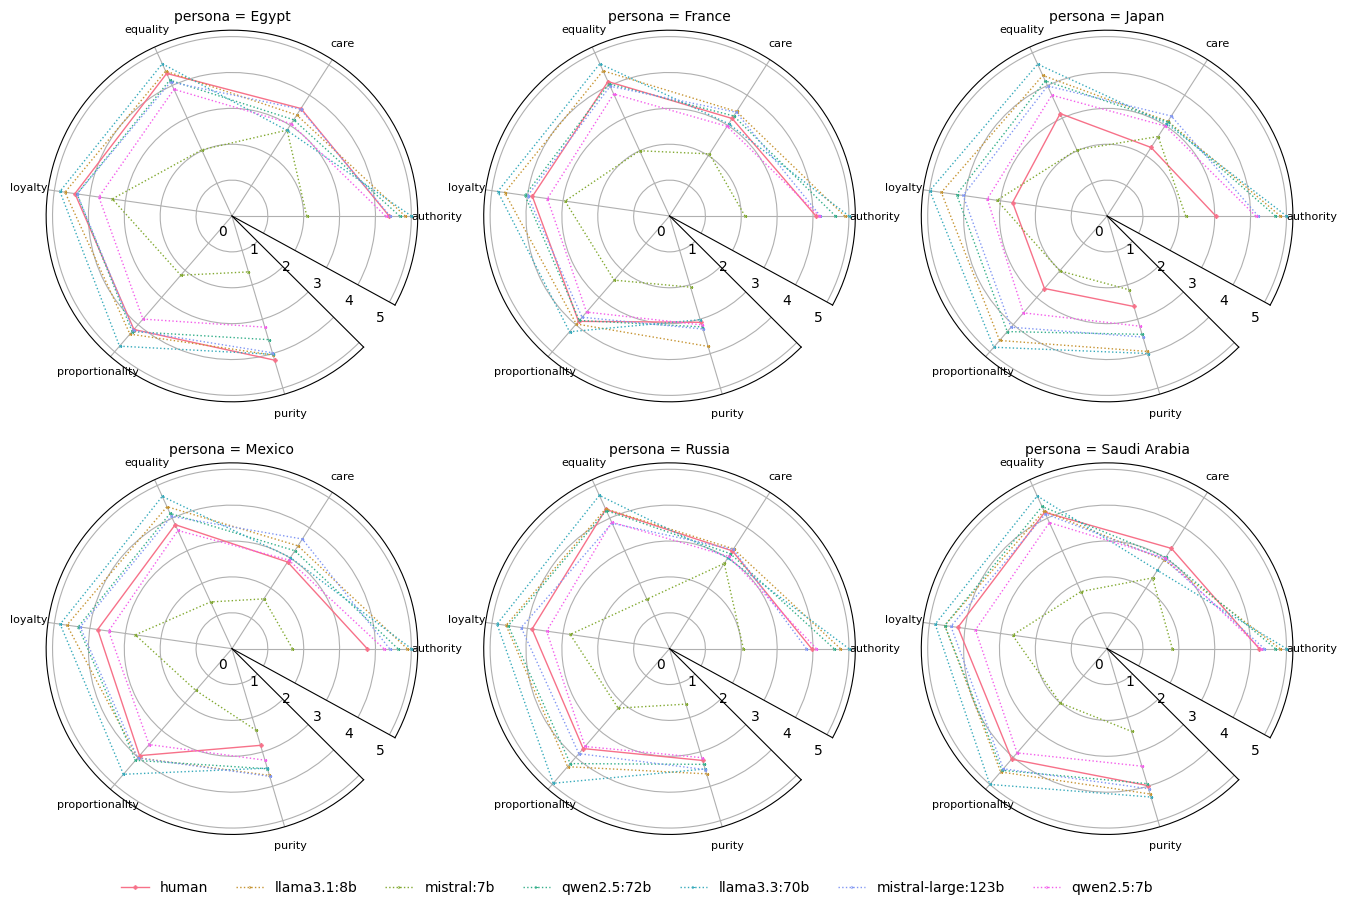

In [ ]:
grid = seaborn.FacetGrid(
    (
        df_prep
        [df_prep["persona"].isin(COUNTRY_FILTER)]
    ), 
    col="persona",
    col_wrap=3,
    height=4.5,
    sharex=False, 
    sharey=True, 
    despine=False,
    subplot_kws=dict(
        projection='polar',
    ),
)

grid.map_dataframe(
    seaborn.pointplot, 
    x="dimension_projection", 
    y="response",
    hue="model",
    lw=1,
    markers=["P"] + ["4"] * (len(df_prep["model"].unique()) - 1),
    linestyles=["-"] + [":"] * (len(df_prep["model"].unique()) - 1),
    palette=seaborn.color_palette("husl", len(df_prep["model"].unique()))
)

grid.add_legend(
    title="",
    bbox_to_anchor=(0.5, 0.0),
    ncol=int(len(df_prep["persona"].unique())),
)

for ax in grid.axes.flat:
    ax.grid(True)

    # ax.set_title(ax.get_title(), pad=20)
    
    ax.set_xlabel(xlabel="")
    ax.set_ylabel(ylabel="")

    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(list(dataset_long["dimension"].cat.categories))
    ax.tick_params(axis='x', labelsize=8)

grid.savefig("reports/polar.dimensions.by_persona.pdf")

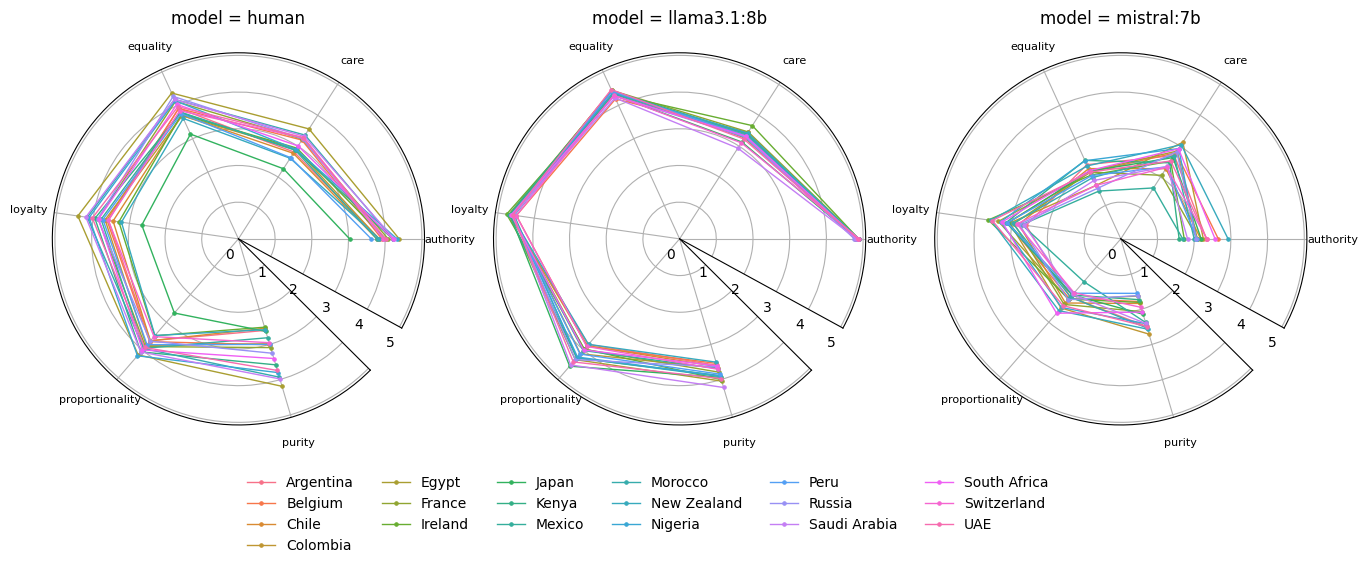

In [ ]:
grid = seaborn.FacetGrid(
    (
        df_prep
        [df_prep["model"].isin(MODEL_FILTER)]
    ), 
    col="model",
    col_wrap=3,
    hue="persona",
    height=4.5,
    sharex=True, 
    sharey=True, 
    despine=False,
    subplot_kws=dict(projection='polar'),
)

grid.map_dataframe(
    seaborn.pointplot, 
    x="dimension_projection", 
    y="response",
    lw=1
)

grid.add_legend(
    title="",
    bbox_to_anchor=(0.5, -0.1),
    ncol=int(len(df_prep["persona"].unique()) / 3),
)

for ax in grid.axes.flat:
    ax.grid(True)

    ax.set_title(ax.get_title(), pad=20)
    
    ax.set_xlabel(xlabel="")
    ax.set_ylabel(ylabel="")

    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(list(dataset_long["dimension"].cat.categories))
    ax.tick_params(axis='x', labelsize=8, pad=8)

grid.savefig("reports/polar.dimensions.by_model.pdf")


In [214]:
(
    df_prep
    .groupby(["model", "persona", "dimension"])
    ["response"]
    .agg("mean")
    .to_frame()
    .reset_index()
    .pipe(lambda _df: _df[_df["persona"].isin(COUNTRY_FILTER)])
    .pivot(index=["persona", "dimension"], columns=["model"], values=["response"])
    # styling
    .style
    .map_index(
        lambda v: "rotatebox:{65}--rwrap--latex;", level=1, axis=1
    )  
    .format(precision=3) 
    # .to_latex(convert_css=True)
)

In [213]:
(
    df_prep
    .set_index(["model", "persona", "dimension"])
    [["response"]]
    .reset_index()
    .pipe(
        lambda _df: (
            _df
            [
                _df["model"].isin(["human", "llama3.1:8b", "llama3.3:70b"]) &
                _df["persona"].isin(COUNTRY_FILTER)
            ]
        )
    )
    .pivot(
        index=["dimension"],
        columns=["model", "persona"],
        values="response"
    )
    .corr(numeric_only=True)
    .xs('human', level='model', axis=1, drop_level=False)
    # styling
    .style
    .background_gradient()
    .format(precision=3)  
    #.to_latex(convert_css=True, clines="all;data", hrules=True)
)

In [306]:
(
    dataset_long
    .reset_index()
    .groupby(["id", "model", "persona"], observed=False)
    ["response"]
    .agg(list)
    .groupby(["id", "model"], observed=False)
    .agg(lambda row: scipy.stats.f_oneway(*row.values).pvalue)
    .unstack(level="model")
    .pipe(lambda _df: _df.assign(MEAN=_df.mean(axis=1)))
    .pipe(lambda _df: pandas.concat([
        _df, pandas.DataFrame([_df.mean()], index=["MEAN"])
    ]))
    .rename_axis(columns=None)
    .style
    .map(lambda v: 'opacity: 50%; color:red;' if (v > 0.05) else None)
    .highlight_null(props='opacity: 50%; color:red;')
    .map_index(
        lambda v: "rotatebox:{65}--rwrap--latex;", level=0, axis=1
    ) 
    .format(precision=5)
    # .to_latex(convert_css=True, clines="all;data", hrules=True)
)

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,llama3.1:8b,mistral:7b,qwen2.5:72b,llama3.3:70b,mistral-large:123b,qwen2.5:7b,MEAN
1,0.01844,0.49854,0.00025,nan,0.00012,0.00151,0.10377
2,0.51522,nan,0.00000,nan,0.00000,0.10831,0.15588
3,0.04875,0.48597,0.04996,0.00000,0.05882,0.00133,0.10747
4,0.00003,0.11762,0.00000,0.00000,0.00000,0.00000,0.01961
5,0.00000,0.67451,0.00000,0.00000,0.00000,0.00000,0.11242
6,0.00029,0.11606,0.00000,0.00000,0.00000,0.00000,0.01939
7,0.47381,0.67889,0.00000,nan,0.18223,0.00000,0.26699
8,0.57577,0.11295,0.00501,0.00000,0.00000,0.00026,0.11566
9,0.51935,0.20308,0.00001,0.45691,0.54639,0.00000,0.28763
10,0.37501,0.05758,0.00000,nan,0.00000,0.00000,0.08652


In [20]:
(
    dataset_long
    .reset_index()
    .groupby(["id", "dimension", "model", "persona"], observed=True)
    ["response"]
    .agg(list)
    .groupby(["id", "dimension", "model"], observed=True)
    .agg(lambda row: scipy.stats.f_oneway(*row.values).pvalue)
    .unstack(level="model")
    .groupby("dimension", observed=True)
    .agg("mean")
    .rename_axis(columns=None)
    .style
    .map(lambda v: 'opacity: 50%; color:red;' if (v > 0.05) else None)
    .highlight_null(props='opacity: 50%; color:red;')
    .map_index(
        lambda v: "rotatebox:{65}--rwrap--latex;", level=0, axis=1
    ) 
    .format(precision=5)
)

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,llama3.1:8b,mistral:7b,qwen2.5:72b,llama3.3:70b,mistral-large:123b,qwen2.5:7b
dimension,,,,,,
authority,0.00561,0.50922,0.15039,0.00000,0.00000,0.00000
care,0.15502,0.37450,0.08070,nan,0.03044,0.00754
equality,0.25187,0.19165,0.01030,0.00000,0.00282,0.01931
loyalty,0.08395,0.18021,0.00000,0.00000,0.00240,0.02932
proportionality,0.36236,0.39304,0.10164,0.11423,0.12540,0.00344
purity,0.11811,0.50123,0.00137,0.07615,0.00189,0.00113


In [ ]:
import json
import glob 

print(
    pandas.concat(
        [
            pandas.json_normalize(json.load(open(file))).assign(participant=n)
            for n, file in enumerate(glob.glob("data/new-zealand/**/*.json", recursive=True))
        ],
    )
    .pipe(lambda _df: _df.assign(response=pandas.to_numeric(_df["response"], errors='coerce')))
    .pivot_table(
        values="response",
        index="participant",
        columns="dimension",
        aggfunc="mean"
    )
    .round(1)
    .to_csv(index=False, na_rep="NA")
)

authority,care,equality,loyalty,proportionality,purity
4.2,4.8,3.8,4.2,4.0,3.5
4.0,4.6,3.2,4.4,4.2,3.0
4.2,4.2,3.2,4.4,4.0,3.2
3.8,4.0,4.2,4.0,4.2,3.2
4.3,4.7,4.0,4.3,3.7,3.6
4.0,3.5,3.5,4.0,4.3,3.5
4.0,4.5,4.0,4.2,4.0,3.5
4.0,4.0,3.8,4.2,3.8,3.2
4.0,4.2,3.8,4.3,3.7,4.0
3.8,4.3,3.3,4.0,3.8,3.2
4.5,4.7,3.3,4.2,4.0,3.6
3.2,4.7,3.8,4.3,4.4,3.6
4.0,4.3,3.3,4.4,4.5,4.0
3.8,4.2,3.8,4.2,4.2,4.2
3.8,4.8,3.8,3.8,4.2,3.5
3.4,4.4,2.7,3.7,4.0,3.8
4.2,4.2,3.5,4.3,4.0,3.6
4.0,4.8,3.5,4.4,4.3,3.7
3.7,4.2,3.6,4.8,4.4,3.8
4.0,4.2,4.0,4.0,4.0,3.6
4.0,3.8,4.2,4.0,4.0,3.6
4.3,4.0,3.6,4.8,3.7,3.2
3.8,4.3,3.7,3.6,4.2,3.3
4.2,4.0,3.5,3.8,4.0,2.8
3.8,4.7,3.4,3.8,4.5,3.8
4.3,4.7,4.2,4.2,4.3,3.4
4.0,5.0,3.5,4.0,4.2,3.6
4.0,4.2,4.0,4.0,3.7,3.2
3.8,4.0,3.8,4.5,4.2,3.6
4.2,4.0,3.7,4.6,4.3,3.7
4.2,4.5,3.2,4.0,4.4,3.3
3.6,4.2,3.8,4.2,4.5,3.8
4.2,4.2,3.5,4.5,4.2,3.0
3.5,4.4,4.2,4.5,3.6,3.2
4.3,4.0,3.7,4.4,4.7,3.4
3.8,4.4,3.2,4.4,4.4,3.0
4.0,4.2,3.0,4.0,4.3,3.2
4.2,4.0,3.8,4.5,3.8,3.2
4.3,4.4,3.8,4.4,4.2,4.5
3.7,4.4,3